In [1]:
%matplotlib inline
from IPython.display import clear_output
import os
from copy import deepcopy

import torch
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models import ConvNet
from helper import ExperimentLogger, display_train_stats
from fl_devices import Server, Client
from data_utils import split_noniid, CustomSubset, iid_partition, split_noniid1
from torch.utils.data import DataLoader, Subset
from collections import defaultdict

torch.manual_seed(42)
np.random.seed(42)

c:\Users\ompi\anaconda3\envs\b_cfl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will run experiments with the EMNIST data set of handwritten characters. We simulate a scenario with 10 clients and distribute the data among the clients in a non-iid way accoding to a dirichlet distribution parametrized with alpha=1.0 . The distribution of data is shown below.

In [2]:
# Parameters for your dataset and client split
DIRICHLET_ALPHA = 0.75  # Example alpha for Dirichlet distribution
N_CLIENTS = 10         # Example number of clients

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor (mean=0.5, std=0.5 for MNIST)
])

# Load the MNIST dataset
data = datasets.MNIST(root=".", download=True, transform=transforms.ToTensor())

# Map for character labels (assuming it's a character-based label set, as indicated in your array)
mapp = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

# Split data by class
class_data = defaultdict(list)
for idx, (image, label) in enumerate(data):
    class_data[label].append(idx)

# Now we split the data into training and test sets (as per your existing code logic)
idcs = np.random.permutation(len(data))
train_idcs, test_idcs = idcs[:10000], idcs[10000:20000]

# Creating the test data subset
test_data = Subset(data, test_idcs)


# Get the labels of the training data
train_labels = np.array([label for _, label in data])

# Apply the non-IID splitting logic
#client_idcs = split_noniid(train_idcs, train_labels, alpha=DIRICHLET_ALPHA, n_clients=N_CLIENTS)
#client_idcs = split_noniid(data, num_clients=N_CLIENTS, class_split_ratio=DIRICHLET_ALPHA)
client_idcs = split_noniid1(data, num_clients=N_CLIENTS)
#client_idcs = iid_partition(data, num_clients=N_CLIENTS)

# Create client-specific datasets
client_data = [CustomSubset(data, client_indices) for client_indices in client_idcs]

# If needed, create data loaders
client_loaders = [DataLoader(client, batch_size=32, shuffle=True) for client in client_data]

# Optionally, if you need to test the data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)



c:\Users\ompi\anaconda3\envs\b_cfl\lib\site-packages\numpy\core\fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
c:\Users\ompi\anaconda3\envs\b_cfl\lib\site-packages\matplotlib\cbook\__init__.py:1395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


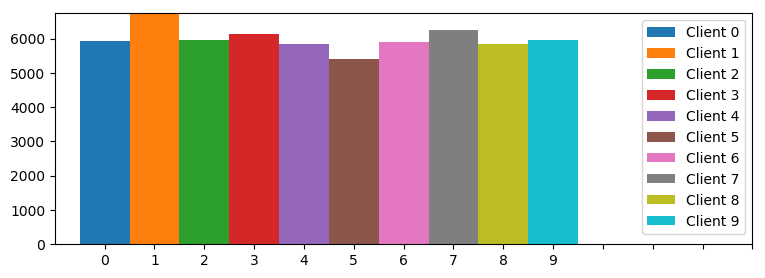

In [3]:
plt.figure(figsize=(9,3))
plt.hist([train_labels[idc]for idc in client_idcs], stacked=True, 
         bins=np.arange(min(train_labels)-0.5, max(train_labels) + 1.5, 1),
        label=["Client {}".format(i) for i in range(N_CLIENTS)])
plt.xticks(np.arange(14), mapp)
plt.legend()
plt.show()

Next, we simulate a clustering structure in the client population, by rotating the data for half of the first 5 clients by 180 degree. We display 10 data samples from the 1st and the 6th client for illustration.

In [4]:
'''
for i, client_datum in enumerate(client_data):
    if i<5:
        client_datum.subset_transform = transforms.Compose([transforms.RandomRotation((180,180)),
                                                      transforms.ToTensor()])
    else:
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])
'''        
for i, client_datum in enumerate(client_data):
    if i<5:
        client_datum.subset_transform = transforms.Compose([transforms.RandomRotation((180,180))])

In [5]:
clients = [Client(ConvNet, lambda x : torch.optim.SGD(x, lr=0.01, momentum=0.9), dat, idnum=i) 
           for i, dat in enumerate(client_data)]
server = Server(ConvNet, test_data)

#ici 

Now everything is set up to run our Clustered Federated Learning algorithm. During training, we will track the mean and std client accuracies, as well as the average and maximum client update norms.

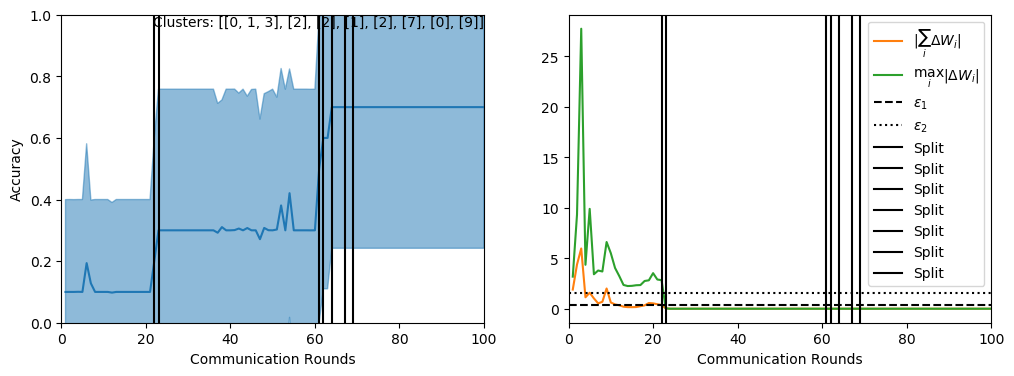

In [6]:
COMMUNICATION_ROUNDS = 100
EPS_1 = 0.4
EPS_2 = 1.6
    
    
cfl_stats = ExperimentLogger()
    
cluster_indices = [np.arange(len(clients)).astype("int")]
client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]


for c_round in range(1, COMMUNICATION_ROUNDS+1):

    if c_round == 1:
        for client in clients:
            client.synchronize_with_server(server)
            
    participating_clients = server.select_clients(clients, frac=1.0)

    for client in participating_clients:
        train_stats = client.compute_weight_update(epochs=1)
        client.reset()

    similarities = server.compute_pairwise_similarities(clients)

    cluster_indices_new = []
    for idc in cluster_indices:
        max_norm = server.compute_max_update_norm([clients[i] for i in idc])
        mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])
             
        if mean_norm<EPS_1 and max_norm>EPS_2 and len(idc)>2 and c_round>20:
            
            server.cache_model(idc, clients[idc[0]].W, acc_clients)
            
            c1, c2 = server.cluster_clients(similarities[idc][:,idc]) 
            cluster_indices_new += [c1, c2]
             
            cfl_stats.log({"split" : c_round})

        else:
            cluster_indices_new += [idc]
        
        
    cluster_indices = cluster_indices_new
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

    server.aggregate_clusterwise(client_clusters)

    acc_clients = [client.evaluate() for client in clients]
    
    cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                  "rounds" : c_round, "clusters" : cluster_indices})
    
    
    display_train_stats(cfl_stats, EPS_1, EPS_2, COMMUNICATION_ROUNDS)

    
for idc in cluster_indices:    
    server.cache_model(idc, clients[idc[0]].W, acc_clients)

In [7]:

# Evaluate the final test accuracy across all clients
test_accuracies = []
for client in clients:
    test_accuracy = [client.evaluate() for client in clients]
    test_accuracies.append(test_accuracy)

mean_test_accuracy = np.mean(test_accuracies)
cfl_stats.log({"mean_test_accuracy": mean_test_accuracy})
print(f"Mean Test Accuracy after {COMMUNICATION_ROUNDS} rounds: {mean_test_accuracy:.4f}")

Mean Test Accuracy after 100 rounds: 0.7000


The training process resulted in multiple models for every client: A Federated Learning base model as well as more specialized models for the different clusters.  We can now compare their accuracies on the clients' validation sets, and assign each client the model which performed best.

In [8]:
results = np.zeros([100, len(server.model_cache)])
for i, (idcs, W, accs) in enumerate(server.model_cache):
    results[idcs, i] = np.array(accs)

In [9]:
frame = pd.DataFrame(results, columns=["FL Model"]+["Model {}".format(i) 
                                                    for i in range(results.shape[1]-1)],
            index = ["Client {}".format(i) for i in range(results.shape[0])])

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
frame.T.style.apply(highlight_max)

,Client 0,Client 1,Client 2,Client 3,Client 4,Client 5,Client 6,Client 7,Client 8,Client 9,Client 10,Client 11,Client 12,Client 13,Client 14,Client 15,Client 16,Client 17,Client 18,Client 19,Client 20,Client 21,Client 22,Client 23,Client 24,Client 25,Client 26,Client 27,Client 28,Client 29,Client 30,Client 31,Client 32,Client 33,Client 34,Client 35,Client 36,Client 37,Client 38,Client 39,Client 40,Client 41,Client 42,Client 43,Client 44,Client 45,Client 46,Client 47,Client 48,Client 49,Client 50,Client 51,Client 52,Client 53,Client 54,Client 55,Client 56,Client 57,Client 58,Client 59,Client 60,Client 61,Client 62,Client 63,Client 64,Client 65,Client 66,Client 67,Client 68,Client 69,Client 70,Client 71,Client 72,Client 73,Client 74,Client 75,Client 76,Client 77,Client 78,Client 79,Client 80,Client 81,Client 82,Client 83,Client 84,Client 85,Client 86,Client 87,Client 88,Client 89,Client 90,Client 91,Client 92,Client 93,Client 94,Client 95,Client 96,Client 97,Client 98,Client 99
FL Model,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Model 0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Model 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Model 2,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

As we can see, clustering improoved the accuracy for all clients by about 10%.